# Star Sims

Contact author: Alex Broughton


## Introduction

- Generate simulation of realistic PSF stars using descwl-shear-sims 
- Simulate stars with/without silicon sensor effects (incl. the BFE)
- Accurately measure the shapes of the stars
- Calculate HOM residuals of stars
<!--- - Adopt Monte Carlo test of shape bias with Latin hypercube sampling --->

## 1.0 Set Up

To begin, let's set up a few packages. Nominally, we will operate using the $\texttt{desc-stack-weekly}$ kernel which should make available most of all lsst tools we will need. In addition, we will need to get the $\texttt{desc-wl-shear}$ package as well as $\texttt{metadetect}$ and a few other supporting packages. 

Since the main branch of each of these reposisitories is not complete enough for our purposes, you must use my own local branches of these packages. In my branch, I have added configurations for the BFE as well as updated it to work with later versions of the LSST Stack. 

As a general practice, I recommend that you create a directory in you home directory called localpackages, and add this to your path. Any code you generate, you can just dump into that directory and install it with $\texttt{pip}$, and you will be able to use anywhere on your system. Once you do this with the additional repositories, you will not need to run it again.

In [1]:
# Import packages:
import os
import sys
import numpy as np
import glob
import joblib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import galsim
from tqdm.auto import tqdm
from scipy.ndimage import gaussian_filter

import lsst.afw.image as afw_image
import lsst.afw.geom as afw_geom

In [2]:
# Set some environment variables
os.environ["CATSIM_DIR"] = "/global/homes/a/ambrough/bfxshear/data/catsim"

os.environ['SAVESIM'] = "1" # True/False
os.environ['SIMOUT'] = os.environ['PSCRATCH'] + "/data/test/test"

In [3]:
# !{sys.executable} -m pip install /global/u1/a/ambrough/bfxshear/descwl-shear-sims/descwl-shear-sims --target /global/homes/a/ambrough/localpackages
# !{sys.executable} -m pip install /global/u1/a/ambrough/bfxshear/descwl_coadd --target /global/homes/a/ambrough/localpackages
# !{sys.executable} -m pip install /global/u1/a/ambrough/bfxshear/WeakLensingDeblending --target /global/homes/a/ambrough/localpackages
# !{sys.executable} -m pip install /global/u1/a/ambrough/bfxshear/ngmix --target /global/homes/a/ambrough/localpackages
# !{sys.executable} -m pip install /global/u1/a/ambrough/bfxshear/metadetect --target /global/homes/a/ambrough/localpackages
# !{sys.executable} -m pip install /global/u1/a/ambrough/bfxshear/meds --target /global/homes/a/ambrough/localpackages


In [4]:
# Import local packages:
sys.path.append("/global/homes/a/ambrough/localpackages")
from descwl_shear_sims.galaxies import (make_galaxy_catalog,
                                        FixedGalaxyCatalog,
                                        WLDeblendGalaxyCatalog,)
from descwl_shear_sims.stars import make_star_catalog, StarCatalog
from descwl_shear_sims.psfs import make_ps_psf, make_fixed_psf
from descwl_shear_sims.sim import get_se_dim, make_sim

%matplotlib inline

In [5]:
# Plotting style
matplotlib.rcParams.update({'font.size': 14})
plt.style.use('tableau-colorblind10')

# Set up some plotting defaults:

params = {'axes.labelsize': 13,
          'font.size': 14,
          'legend.fontsize': 12,
          'xtick.major.width': 1.5,
          'xtick.minor.width': 1,
          'xtick.major.size': 6,
          'xtick.minor.size': 3,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 1.5,
          'axes.linewidth': 1.5,
          'axes.labelweight': 1.5,
          'axes.titleweight': 1.5,
          'ytick.major.width': 1.5,
          'ytick.minor.width': 1,
          'ytick.major.size': 6,
          'ytick.minor.size': 3,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [7, 7],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

## 2.0 Simple Simulation

Simple simulation of galaxies.

*Note: Objects brighter than magntiude 17 (e.g., 14
    since mags are opposite) tend to cause the Rubin Observatory science
    pipeline detection algorithm to misdetect isolted objects in unphysical
    ways. This effect causes the shear response to be non-linear and so
    metadetect will fail. For this reason, you should use the default
    magnitude of 17 or fainter for this kind of galaxy.}*

In [6]:
# Optional: see all config options for make_sim()
# make_sim?

In [7]:
%%time

# Make a constant PSF
psf = make_fixed_psf(psf_type='gauss', psf_fwhm=0.4)

seed = 8312
rng = np.random.RandomState(seed)

coadd_dim = 351

# Make star catalog
star_catalog = make_star_catalog(
    rng=rng,
    coadd_dim=coadd_dim,
    layout='grid',
    mag=15.5,
    #star_config={'density':5}
)

# Make a dummy galaxy catalog
# The program cannot run without a galaxy catalog, 
# so we need to put one in, but it won't draw onto 
# the image.
dummy_galaxy_catalog = FixedGalaxyCatalog(
        rng=rng,
        coadd_dim=coadd_dim,
        buff=0, # Ignored when layout is not 'random'
        layout='grid',
        mag=26,
        hlr=1.0,
)

# Generate some simulation data, with a particular shear
# (there are also a few dummy parameters here that do not apply to stars)
sim_data = make_sim(
    rng=rng,
    galaxy_catalog=dummy_galaxy_catalog,
    star_catalog=star_catalog,
    coadd_dim=coadd_dim,
    g1=0,
    g2=0,
    psf=psf,
    sky_n_sigma=0.0,
    noise_factor=1.0,
    draw_method="phot",
    bands=['i'],
    star_bleeds=False,
    draw_stars=True,
    draw_gals=False,
    bf_strength=0,
    diffusion_strength=0,
    nrecalc=1000,
    verbose=True,
)

nrecalc for obj #1 (f=630957.3444801943): 1000
nrecalc for obj #2 (f=630957.3444801943): 1000
nrecalc for obj #3 (f=630957.3444801943): 1000
nrecalc for obj #4 (f=630957.3444801943): 1000
nrecalc for obj #5 (f=630957.3444801943): 1000
nrecalc for obj #6 (f=630957.3444801943): 1000
nrecalc for obj #7 (f=630957.3444801943): 1000
nrecalc for obj #8 (f=630957.3444801943): 1000
nrecalc for obj #9 (f=630957.3444801943): 1000
nrecalc for obj #10 (f=630957.3444801943): 1000
nrecalc for obj #11 (f=630957.3444801943): 1000
nrecalc for obj #12 (f=630957.3444801943): 1000
nrecalc for obj #13 (f=630957.3444801943): 1000
nrecalc for obj #14 (f=630957.3444801943): 1000
nrecalc for obj #15 (f=630957.3444801943): 1000
nrecalc for obj #16 (f=630957.3444801943): 1000
nrecalc for obj #17 (f=630957.3444801943): 1000
nrecalc for obj #18 (f=630957.3444801943): 1000
nrecalc for obj #19 (f=630957.3444801943): 1000
nrecalc for obj #20 (f=630957.3444801943): 1000
nrecalc for obj #21 (f=630957.3444801943): 1000
n

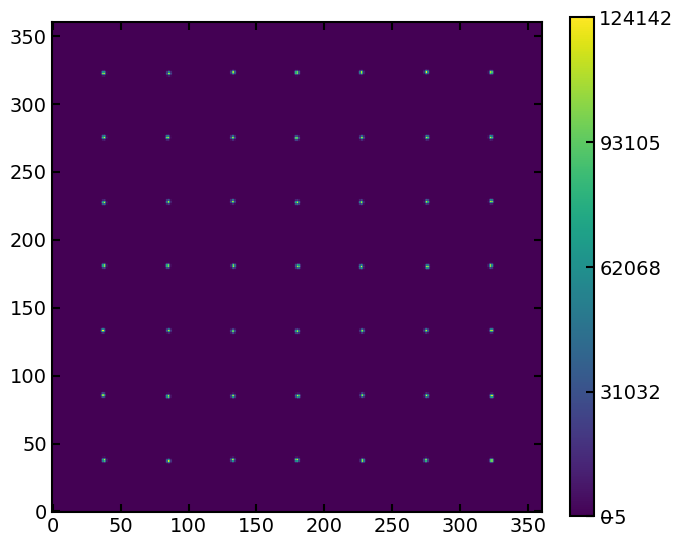

In [8]:
def display_img(data, nticks=5, include_zero=True, center_zero=False, cmap='viridis'):
    if center_zero:
        assert np.min(data) < 0 and np.max(data) > 0
        norm = colors.TwoSlopeNorm(vmin=np.min(data), vcenter=0, vmax=np.max(data))
        im = plt.imshow(data, origin="lower", cmap=cmap, interpolation='nearest', norm=norm)
    else:
        im = plt.imshow(data, origin="lower", cmap=cmap, interpolation='nearest')
    cbar = plt.colorbar(im,fraction=0.046)
    
    cbar_ticks = np.linspace(np.min(data), np.max(data), nticks)
    if include_zero:
        cbar_ticks = np.append(cbar_ticks, 0)

    cbar.set_ticks(cbar_ticks)

data = sim_data['band_data']['i'][0].getImage().getArray()
display_img(data, nticks=5, include_zero=True, center_zero=False, cmap='viridis')

49 stars
mu = 1.6146306748488732 +/- 0.002399781915890416


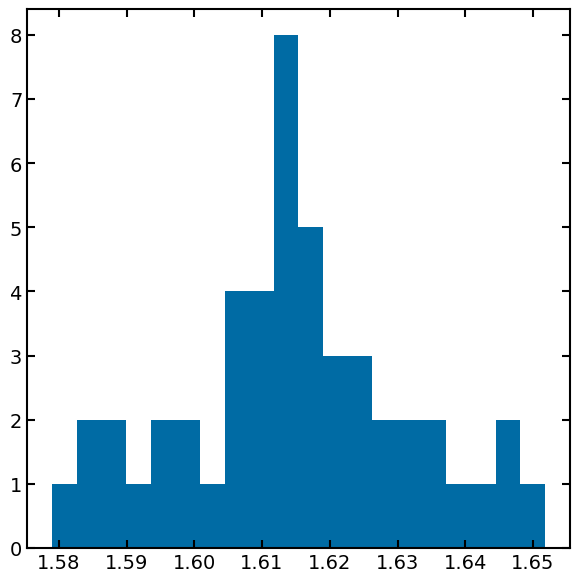

In [9]:
#Check the single sim outputs

outputs = glob.glob(os.environ['SIMOUT'] + "/*.npy")

res=[]
for output in outputs:
    r = np.load(output, allow_pickle=True)
    for i in range(49):
        res.append(2*r[i].moments_sigma**2)

        
_=plt.hist(res, bins=20)
print(len(res), "stars")
print("mu =", np.mean(res), "+/-", np.std(res)/np.sqrt(len(res)))

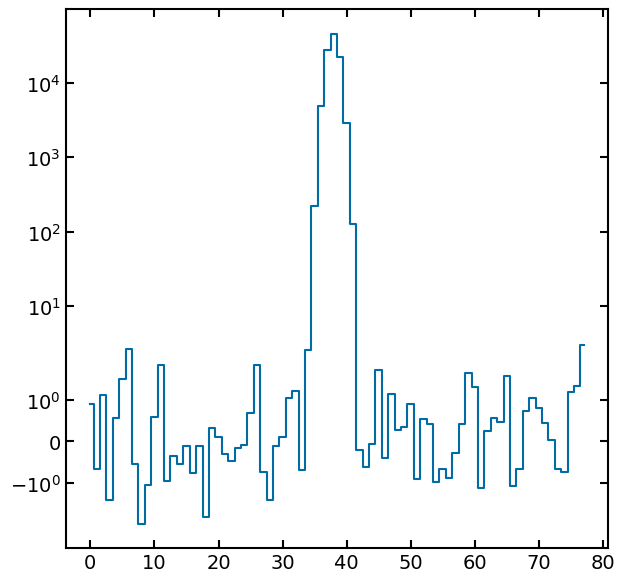

In [10]:
# Plot a slice through the middle of a star
_ = plt.plot(data[39,0:39*2], drawstyle='steps-mid')
plt.yscale("symlog")

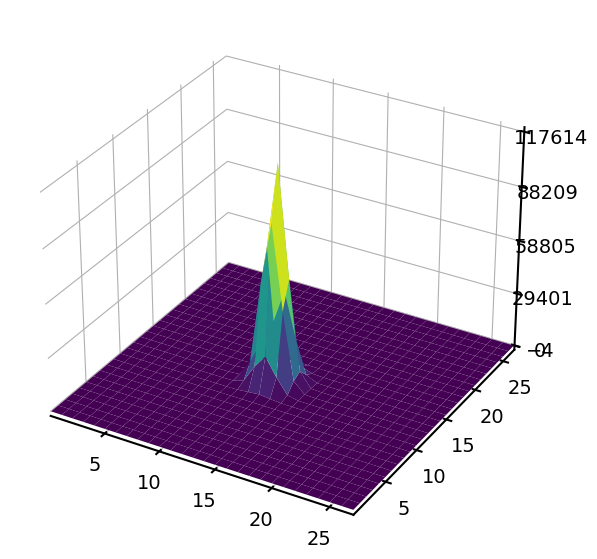

In [11]:
# View the 3d profile of the star
data_sec = data[25:39*2-25,25:39*2-25]
x, y = np.meshgrid(np.arange(data_sec.shape[0]), 
                   np.arange(data_sec.shape[1]))

ax = plt.axes(projection='3d')
ax.plot_surface(x, y, data_sec, rstride=1, cstride=1,
                cmap='viridis',edgecolor='none')
zticks = np.linspace(np.min(data_sec), np.max(data_sec), 5)
zticks = np.append(zticks, 0)
_ = ax.set_zticks(zticks)
ax.set_xlim(.5,26.5)
ax.set_ylim(.5,26.5)
#ax.set_zlim(0,30)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


## 3.0 BF/no-BF Simulation

In [12]:
def do_sim(bf_on, seed, mag=14, bf_strength=1, nrecalc=1000, psf_size=0.7):
    # Make a constant PSF
    psf = make_fixed_psf(psf_type='gauss', psf_fwhm=psf_size)

    rng = np.random.RandomState(seed)

    coadd_dim = 351

    # Make star catalog
    star_catalog = make_star_catalog(
        rng=rng,
        coadd_dim=coadd_dim,
        layout='grid',
        mag=mag,
    )   

    # Make a dummy galaxy catalog
    # The program cannot run without a galaxy catalog, 
    # so we need to put one in, but it won't draw onto 
    # the image.
    dummy_galaxy_catalog = FixedGalaxyCatalog(
            rng=rng,
            coadd_dim=coadd_dim,
            buff=0, # Ignored when layout is not 'random'
            layout='grid',
            mag=26,
            hlr=1.0,
    )

    # Generate some simulation data, with a particular shear
    # (there are also a few dummy parameters here that do not apply to stars)
    sim_data = make_sim(
        rng=rng,
        galaxy_catalog=dummy_galaxy_catalog,
        star_catalog=star_catalog,
        coadd_dim=coadd_dim,
        g1=0,
        g2=0,
        psf=psf,
        sky_n_sigma=0.0,
        noise_factor=1.0,
        draw_method="phot",
        bands=['i'],
        star_bleeds=False,
        draw_stars=True,
        draw_gals=False,
        bf_strength=int(bf_on)*bf_strength,
        diffusion_strength=0,
        nrecalc=nrecalc,
        verbose=False,
        psf_size=psf_size
    )
    
    exposure = sim_data['band_data']['i'][0]
    return exposure

In [13]:
# Optional
os.environ['SAVESIM'] = "0"

In [14]:
%%time
image_without_bf = do_sim(bf_on=False, seed=8312)

CPU times: user 19.7 s, sys: 2.54 s, total: 22.2 s
Wall time: 22.2 s


In [15]:
%%time
image_with_bf = do_sim(bf_on=True, seed=8312)

CPU times: user 59.7 s, sys: 1.95 s, total: 1min 1s
Wall time: 1min 1s


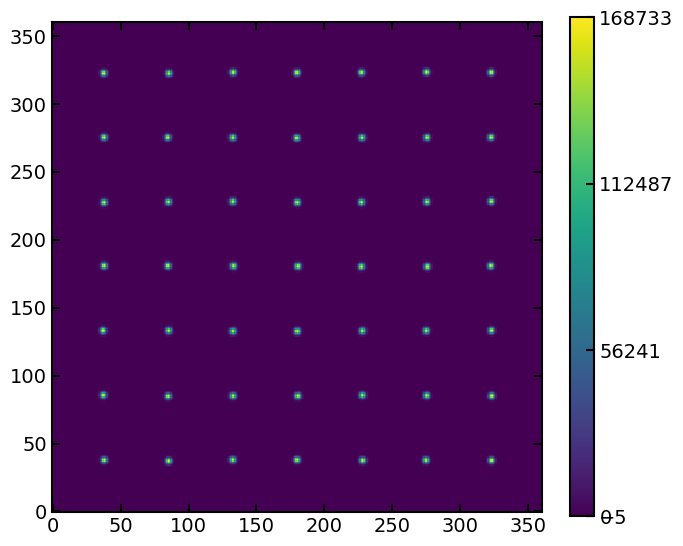

In [16]:
def display_img(data, nticks=5, include_zero=True, center_zero=False, cmap='viridis'):
    import matplotlib.colors as colors
    if center_zero:
        assert np.min(data) < 0
        norm = colors.TwoSlopeNorm(vmin=np.min(data), vcenter=0, vmax=np.max(data))
        im = plt.imshow(data, origin="lower", cmap=cmap, interpolation='nearest', norm=norm)
    else:
        im = plt.imshow(data, origin="lower", cmap=cmap, interpolation='nearest')
    cbar = plt.colorbar(im,fraction=0.046)
    
    cbar_ticks = np.linspace(np.min(data), np.max(data), nticks)
    if include_zero:
        cbar_ticks = np.append(cbar_ticks, 0)

    cbar.set_ticks(cbar_ticks)

display_img(image_with_bf.getImage().getArray(), nticks=4)

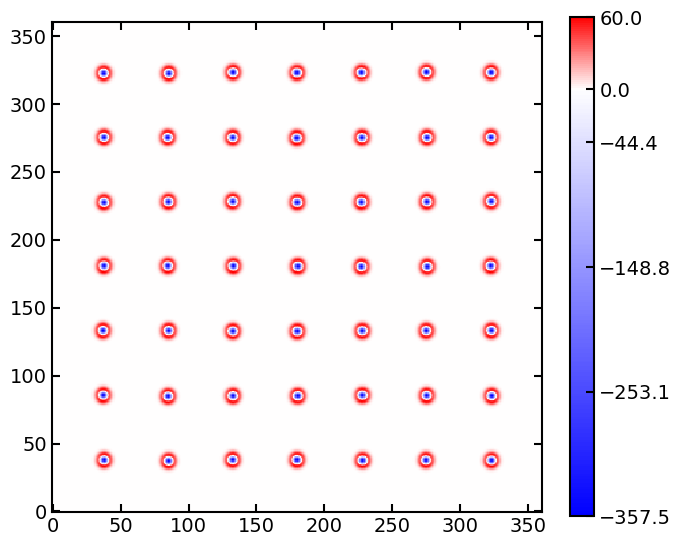

In [17]:
diff = (image_with_bf.getImage().getArray() - image_without_bf.getImage().getArray())
from matplotlib.colors import SymLogNorm
from scipy.ndimage import gaussian_filter

n_sigma_smoothing = 2

display_img(gaussian_filter(diff,n_sigma_smoothing), nticks=5, include_zero=True, center_zero=True, cmap='bwr')


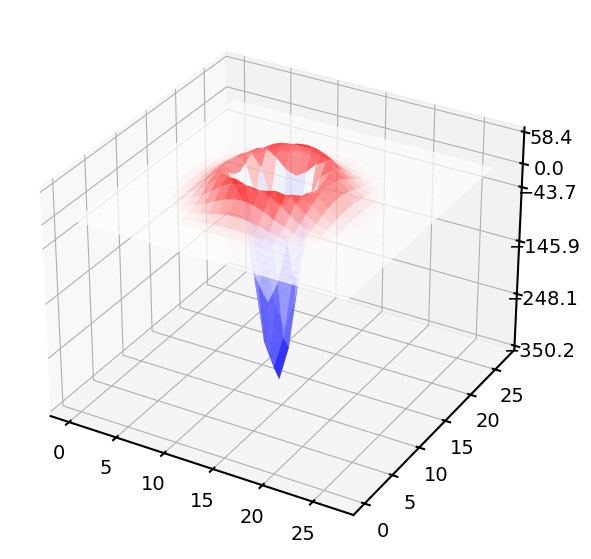

In [18]:
data_sec = gaussian_filter(diff,n_sigma_smoothing)[25:39*2-25,25:39*2-25]
x, y = np.meshgrid(np.arange(data_sec.shape[0]), 
                   np.arange(data_sec.shape[1]))

# Set color bar with 0 at the center
assert np.min(data_sec) < 0 and np.max(data_sec) > 0
norm = colors.TwoSlopeNorm(vmin=np.min(data_sec), vcenter=0, vmax=np.max(data_sec))
    
ax = plt.axes(projection='3d')
ax.plot_surface(x, y, data_sec, rstride=1, cstride=1,
                cmap='bwr', edgecolor='none', norm=norm, alpha=0.75)
zticks = np.linspace(np.min(data_sec), np.max(data_sec), 5)
zticks = np.append(zticks, 0)
_ = ax.set_zticks(zticks)


In [21]:
del image_without_bf
del image_with_bf

## 4.0 Test $\texttt{drawImage()}$ settings

Questions:
1. What is bf_strength actually doing?
2. How are the fluxes really determined?

### 4.1 Set Up

In [22]:
# Configuration matrix
nrecalcs = np.flip(np.logspace(0, 4, 5, base=10))
bf_strengths = np.asarray([1.0, 2.0, 5.0,10.0])
mags = [15.5] #np.linspace(15.5, 17, 3) 
psf_sizes = [0.4] #np.array([0.4, 2.0])

In [20]:
# Fast one to test
nrecalcs = [1000]
bf_strengths = [1]
mags = [15.5]
psf_sizes = [0.4]

In [25]:
# Optional (recommended)
def do_sim(bf_on, seed, mag=14, bf_strength=1, nrecalc=1000, psf_size=0.7):
    # Make a constant PSF
    psf = make_fixed_psf(psf_type='gauss', psf_fwhm=psf_size)

    rng = np.random.RandomState(seed)

    coadd_dim = 351

    # Make star catalog
    star_catalog = make_star_catalog(
        rng=rng,
        coadd_dim=coadd_dim,
        layout='grid',
        mag=mag,
    )   

    # Make a dummy galaxy catalog
    # The program cannot run without a galaxy catalog, 
    # so we need to put one in, but it won't draw onto 
    # the image.
    dummy_galaxy_catalog = FixedGalaxyCatalog(
            rng=rng,
            coadd_dim=coadd_dim,
            buff=0, # Ignored when layout is not 'random'
            layout='grid',
            mag=26,
            hlr=1.0,
    )

    # Generate some simulation data, with a particular shear
    # (there are also a few dummy parameters here that do not apply to stars)
    sim_data = make_sim(
        rng=rng,
        galaxy_catalog=dummy_galaxy_catalog,
        star_catalog=star_catalog,
        coadd_dim=coadd_dim,
        g1=0,
        g2=0,
        psf=psf,
        sky_n_sigma=0.0,
        noise_factor=1.0,
        draw_method="phot",
        bands=['i'],
        star_bleeds=False,
        draw_stars=True,
        draw_gals=False,
        bf_strength=int(bf_on)*bf_strength,
        diffusion_strength=0,
        nrecalc=nrecalc,
        verbose=False,
        psf_size=psf_size
    )

    # Don't return exposure 
    # to save space
    return 1

def do_parallel(bf_on, seed, mag=14, bf_strength=1, nrecalc=1000, psf_size=0.7,
                ntrial=3, nsub=3, n_jobs=1):

    nsub = max(ntrial // 100, nsub)
    nitr = ntrial // nsub

    rng = np.random.RandomState(seed=seed)
    seeds = rng.randint(low=1, high=2**29, size=ntrial)

    loc = 0
    for itr in range(nitr):
        # For each itr, submit nsub jobs
        # Pass it different seeds each time
        jobs = [
                joblib.delayed(do_sim)(
                    bf_on=bf_on, seed=seeds[loc+i], 
                    mag=mag, 
                    bf_strength=bf_strength, 
                    nrecalc=nrecalc, 
                    psf_size=psf_size,
                ) for i in range(nsub)
            ]

        # outputs has length nsub 
        outputs = joblib.Parallel(n_jobs=n_jobs, verbose=0, backend='loky')(jobs)
        del outputs # dump
        loc += nsub

In [26]:
%%time

''' THIS TAKES A WHILE '''

os.environ['SAVESIM'] = "1"

for psf_size in tqdm(psf_sizes, colour="green", desc="PSF Size", position=0, leave=False):
    for mag in tqdm(mags, colour="green", desc=" mag(AB)", position=0, leave=False):
        for bf_strength in tqdm(bf_strengths, colour="green", desc=" BF scale", position=0, leave=False):
            for nrecalc in tqdm(nrecalcs, colour="green", desc="nrecalc", position=0, leave=False):
                #Change outout directory
                os.environ['SIMOUT'] = os.environ['PSCRATCH'] + f"/data/test/mag_{mag}"
                
                # Use do_parallel only if you know 
                # what you are doing
                do_parallel(bf_on=True, 
                            seed=8312, 
                            mag=mag,
                            bf_strength=bf_strength, 
                            nrecalc=nrecalc,
                            psf_size=psf_size
                )

                '''_ = do_sim(bf_on=True, 
                           seed=8312, 
                           mag=mag,
                           bf_strength=bf_strength, 
                           nrecalc=nrecalc,
                           psf_size=psf_size
                    )'''

PSF Size:   0%|          | 0/1 [00:00<?, ?it/s]

 mag(AB):   0%|          | 0/1 [00:00<?, ?it/s]

 BF scale:   0%|          | 0/4 [00:00<?, ?it/s]

nrecalc:   0%|          | 0/5 [00:00<?, ?it/s]

nrecalc:   0%|          | 0/5 [00:00<?, ?it/s]


KeyboardInterrupt

